In [1]:
# import useful lib
import sys, os, re, csv, codecs
import json
import math
import datetime
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# import lib to clear the news
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

# import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation, GRU
from keras.layers import Bidirectional, GlobalMaxPool1D, TimeDistributed,concatenate
from keras.models import Model
from keras import initializers, regularizers, constraints, optimizers, layers

Using TensorFlow backend.


In [2]:
# 价格数据
PRICES_DATA = 'data/stockPrices_raw.json'
# 词向量文件
EMB_FILE = "GloVe/glove.42B.300d.txt"
# 新闻文件
NEWS_FILE = "data/tp.csv"

In [54]:
# 词向量维度
emb_size = 300
# 最大词特征（多少个词）
max_features = 20000
# 新闻最大长度
maxlen = 30
# 新闻时间步
news_timestep = 7
# 数值信息时间步
prices_timestep = 20
# 划分时间点
div_date = '20180101'
bound_date = '20181201'

In [4]:
# 读取数据(pandas.dataframe)
news = pd.read_csv(NEWS_FILE)
# 读取价格数据(dict)
prices = None
with open(PRICES_DATA,'r') as file:
    prices = json.load(file)

In [5]:
# 清洗数据(词性还原)
def clean_news(news_raws):
    lemma=WordNetLemmatizer()
    news_rows=[]
    for i in range(0,len(news_raws)):
        news=str(news_raws[i])
        news=[lemma.lemmatize(w) for w in word_tokenize(str(news).lower())]  # 词性还原
        news=' '.join(news)
        news_rows.append(news)
    return news_rows

In [6]:
# 按照代码划分新闻数据
news_dict = dict()
codes =  news['code'].drop_duplicates() # 得到股票代码
for code in codes:
    code_news= news.loc[news['code']==code].copy(deep=True)
    code_news.reset_index(drop=True,inplace=True)
    code_news['news'] = code_news['headline'] # !更多的文本利用
    code_news['news'] = clean_news(code_news['news'])
    news_dict[code] = pd.DataFrame({'date':code_news['date'],'news':code_news['news']})

In [7]:
# 训练新闻文本数据（用于训练tokenizer）
text_train = news['headline'].loc[news['date']<int(div_date)]
text_train.reset_index(drop=True,inplace=True)
text_train = clean_news(text_train)
# 训练tokenizer（得到word2idx）
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(text_train))
print('the number of different words:',len(tokenizer.word_index))

the number of different words: 6895


In [8]:
# 格式转化（dataframe->dict）
date_news_dict=dict()
for code in codes:
    token_train = tokenizer.texts_to_sequences(news_dict[code]['news'])
    seqs = pad_sequences(token_train,maxlen=maxlen,truncating='post')
    dates = news_dict[code]['date']
    date_news_dict[code]=dict()
    for i in range(len(seqs)):
        date_news_dict[code][dates[i]]=seqs[i]
news_dict = date_news_dict

In [9]:
# 新闻的滑动窗口生成器
def news_window_shift(f_date,t_date,time_dict_data,window_size):
    # 左闭右开
    mindate = datetime.datetime.strptime(f_date,"%Y%m%d")
    maxdate = datetime.datetime.strptime(t_date,"%Y%m%d")-datetime.timedelta(days=1)
    it = mindate
    window_dict = dict()
    while(it<=maxdate):
        today = it.strftime("%Y%m%d")
        window_dict[today]=list()
        for i in range(window_size):
            bf = it - datetime.timedelta(days=window_size-1-i)
            bf = int(bf.strftime("%Y%m%d"))
            if int(bf) in time_dict_data:
                window_dict[today].append(time_dict_data[bf])
            else:
                window_dict[today].append(np.zeros(maxlen))      
        it += datetime.timedelta(days=1)
    return window_dict

In [11]:
# 对数据框内的数值进行归一化
def normalization(data_list):
    scaler = MinMaxScaler(copy=True, feature_range=(0, 1))
    values = np.array([item[1] for item in data_list])
    values = values.reshape(-1,1)
    scaler.fit(values)
    transformed_values = scaler.transform(values)
    transformed_data_list = []
    for i in range(len(data_list)):
        transformed_data_list.append((data_list[i][0],transformed_values[i][0]))
    return transformed_data_list

# 价格的滑动窗口生层器(内层)
def _price_window_shift(f_date,t_date,time_dict_data,window_size):
    data = [item for item in time_dict_data.items()]
    mindate = datetime.datetime.strptime(f_date,"%Y%m%d")
    maxdate = datetime.datetime.strptime(t_date,"%Y%m%d")-datetime.timedelta(days=1)
    windows_dict = dict()
    # ! 可以进一步数据清洗
    for i in range(len(data)):
        cr_date = datetime.datetime.strptime(data[i][0],"%Y-%m-%d")
        if cr_date < mindate:
            continue
        if cr_date > maxdate:
            break
        if i >= window_size-1:
            windows_dict[cr_date.strftime("%Y%m%d")] = normalization(data[i+1-window_size:i+1])
    return windows_dict

# 合并数值数据
def combine_data(tup):
    data_dict = dict()
    tp = tuple(tup)
    num = len(tp)
    for key in tp[0].keys():
        data_dict[key] = list()
        window_size = len((tp[0])[key])
        for i in range(window_size):
            cur_tuple = list()
            for j in range(num):
                cur_tuple.append(((tp[j])[key])[i][1])
            cur_tuple = tuple(cur_tuple)
            data_dict[key].append(cur_tuple)
    return data_dict

# 价格的滑动窗口生层器(表层)
def prices_window_shift(f_date,t_date,time_dict_data,window_size):
    open_dict = _price_window_shift(f_date,t_date,time_dict_data['open'],window_size)
    vol_dict = _price_window_shift(f_date,t_date,time_dict_data['volume'],window_size)
    prices_dict = combine_data((open_dict,vol_dict))
    return prices_dict

In [10]:
def get_train_XY(pv,news,raw_data):
    Y_list = list()
    X_list_p = list()
    X_list_n = list()
    data = [item for item in raw_data['open'].items()]
    num = len(data)
    for i in range(num):
        date = datetime.datetime.strptime(data[i][0],"%Y-%m-%d").strftime("%Y%m%d")
        # next的判断
        if i < num-1:
            if date in pv:
                change = ( data[i+1][1]/data[i][1])-1
                X_list_n.append(news[date])
                X_list_p.append(pv[date])
                Y_list.append(change)
    # 对Y的处理
    Y_list = np.array(Y_list)
    threshhold = 0 # 涨跌平的阈值
    for i in range(len(Y_list)):
        if Y_list[i] > threshhold:
            Y_list[i] = 2
        elif Y_list[i] < -threshhold:
            Y_list[i] = 0
        else:
            Y_list[i] = 1
    n_values=3
    Y_list = Y_list.astype(np.int32)
    Y_list = np.eye(3)[Y_list]
    Y_list.reshape(len(Y_list),3)
    return np.array(X_list_p),np.array(X_list_n),Y_list

In [14]:
# 读取词向量到内存
def get_coefs(word,*arr):
    return word,np.asarray(arr,dtype='float32')
emb_index = dict(get_coefs(*o.strip().split()) for o in open(EMB_FILE))

In [15]:
all_embs = np.stack(emb_index.values())
emb_mean = all_embs.mean()
emb_std = all_embs.std()
word_index = tokenizer.word_index
hit_rate = 0
ft_words = min(max_features,len(word_index))
emb_matrix = np.random.normal(emb_mean,emb_std,(ft_words+1,emb_size))
for word, i in word_index.items():
    if i > ft_words:
        continue
    emb_vector = emb_index.get(word)
    if emb_vector is not None:
        hit_rate += 1
        emb_matrix[i] = emb_vector
    else:
        pass
        #print(word)
hit_rate = hit_rate/ft_words
print(hit_rate)

0.9490935460478608


In [18]:
# 完整模型雏形
date_timestep = news_timestep
article_timestep = maxlen
word_feature_dim = emb_size
article_feature_dim = 50
single_feature_dim = 50
date_feature_dim = 50
analysis_feature_dim = 30

# 词嵌入
embedding_layer = Embedding(ft_words+1,word_feature_dim,weights=[emb_matrix],trainable=False)
# embedding_layer = Embedding(ft_words+1,word_feature_dim)
embedding_layer = TimeDistributed(embedding_layer)
# 篇章理解(双向GRU)
article_layer = Bidirectional(GRU(article_feature_dim, return_sequences=True),name='article')
article_layer = TimeDistributed(article_layer,)
# 时序分析层
date_layer = GRU(date_feature_dim)
# 分析层
analysis_layer = Dense(analysis_feature_dim,activation='sigmoid')
# 决策层
# decision_layer = Dense(3,activation='softmax')

In [21]:
def build_model(code='Default'):
    prices_input  = Input(shape=(prices_timestep,2))
    x1 = GRU(50,return_sequences=True)(prices_input)
    x1 = Dropout(0.2)(x1)
    x1 = GRU(50)(x1)
    x1 = Dropout(0.2)(x1)
    
    news_input = Input(shape=(date_timestep,article_timestep,))
    x2 = embedding_layer(news_input)
    x2 = article_layer(x2)
    x2 = TimeDistributed(GlobalMaxPool1D())(x2) #降维
    x2 = Dropout(0.2)(x2)
    x2 = TimeDistributed(Dense(single_feature_dim,activation='tanh',name=code))(x2)
    x2 = date_layer(x2)
    x2 = Dropout(0.2)(x2)
    
    x = concatenate([x1,x2])
    x = Dense(3,activation='softmax')(x)
    model = Model(inputs=[prices_input, news_input],outputs=x)
    model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
    return model

In [22]:
model = build_model('GOOGL')

In [23]:
from keras.utils import plot_model
print(model.summary())
# plot_model(model, to_file='model_combine.png')

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_4 (InputLayer)             (None, 7, 30)         0                                            
____________________________________________________________________________________________________
time_distributed_3 (TimeDistribu (None, 7, 30, 300)    2068800     input_4[0][0]                    
____________________________________________________________________________________________________
time_distributed_4 (TimeDistribu (None, 7, 30, 100)    105300      time_distributed_3[1][0]         
____________________________________________________________________________________________________
input_3 (InputLayer)             (None, 20, 2)         0                                            
___________________________________________________________________________________________

In [12]:
pv_train = prices_window_shift('20150101',div_date,prices['GOOGL'], prices_timestep)
pv_test = prices_window_shift(div_date,'20181201',prices['GOOGL'], prices_timestep)
news_train = news_window_shift('20150101',div_date,news_dict['GOOGL'], news_timestep)
news_test = news_window_shift(div_date,'20181201',news_dict['GOOGL'], news_timestep)

In [29]:
X_train_p,X_train_n,Y_train = get_train_XY(pv_train,news_train,prices['GOOGL'])
X_test_p,X_test_n,Y_test = get_train_XY(pv_test,news_test,prices['GOOGL'])

In [24]:
model.fit(x=[X_train_p[:700],X_train_n[:700]],y=Y_train[:700],batch_size=16, epochs=50,verbose=1,validation_data=([X_train_p[700:],X_train_n[700:]],Y_train[700:]))

Train on 700 samples, validate on 55 samples
Epoch 1/50
700/700 [==============================] - 11s - loss: 0.7769 - acc: 0.5200 - val_loss: 0.6892 - val_acc: 0.6364
Epoch 2/50
700/700 [==============================] - 4s - loss: 0.7070 - acc: 0.5614 - val_loss: 0.6887 - val_acc: 0.5636
Epoch 3/50
700/700 [==============================] - 5s - loss: 0.7048 - acc: 0.5271 - val_loss: 0.6903 - val_acc: 0.5636
Epoch 4/50
700/700 [==============================] - 5s - loss: 0.6984 - acc: 0.5257 - val_loss: 0.6928 - val_acc: 0.4545
Epoch 5/50
700/700 [==============================] - 4s - loss: 0.7068 - acc: 0.5200 - val_loss: 0.6919 - val_acc: 0.5636
Epoch 6/50
700/700 [==============================] - 5s - loss: 0.6866 - acc: 0.5586 - val_loss: 0.6836 - val_acc: 0.5636
Epoch 7/50
700/700 [==============================] - 5s - loss: 0.6976 - acc: 0.5300 - val_loss: 0.7217 - val_acc: 0.5091
Epoch 8/50
700/700 [==============================] - 5s - loss: 0.7033 - acc: 0.5286 - val_l

In [31]:
model.evaluate(x=[X_test_p,X_test_n],y=Y_test,batch_size=16)
y_pre = model.predict(x=[X_test_p,X_test_n],batch_size=16)

231/231 [==============================] - 0s     


In [41]:
y_pre

(array([], dtype=int64),)


/home/beginner/anaconda3/envs/deeplearning/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.
  """Entry point for launching an IPython kernel.


In [25]:
import matplotlib.pyplot as plt

In [65]:
g_open_raw = [item for item in prices['GOOGL']['open'].items()]
g_open_x = []
g_open_y = []
for item in g_open_raw:
    date = datetime.datetime.strptime(item[0],"%Y-%m-%d").strftime("%Y%m%d")
    if date in pv_test:
        g_open_x.append(item[0])
        g_open_y.append(item[1])

array([[  4.64662105e-01,   2.54220358e-05,   5.35312414e-01],
       [  4.19032536e-02,   2.39225551e-06,   9.58094418e-01],
       [  1.79691911e-01,   1.18760991e-05,   8.20296168e-01],
       [  9.64720130e-01,   2.71951958e-05,   3.52527313e-02],
       [  1.72034591e-01,   8.77495550e-05,   8.27877700e-01],
       [  2.36052409e-01,   8.03108851e-05,   7.63867199e-01],
       [  2.80024320e-01,   5.69082913e-05,   7.19918787e-01],
       [  3.46359849e-01,   4.18614072e-05,   6.53598249e-01],
       [  4.59546398e-04,   1.46632474e-05,   9.99525785e-01],
       [  9.99093890e-01,   6.32679075e-07,   9.05484369e-04],
       [  5.54093540e-01,   1.01992082e-05,   4.45896327e-01],
       [  1.54156806e-02,   1.13034559e-06,   9.84583139e-01],
       [  9.88056302e-01,   3.94462540e-06,   1.19398432e-02],
       [  3.12650889e-01,   1.51265513e-05,   6.87333941e-01],
       [  3.63055378e-01,   2.32589282e-05,   6.36921346e-01],
       [  8.57684731e-01,   6.50269328e-07,   1.4231462

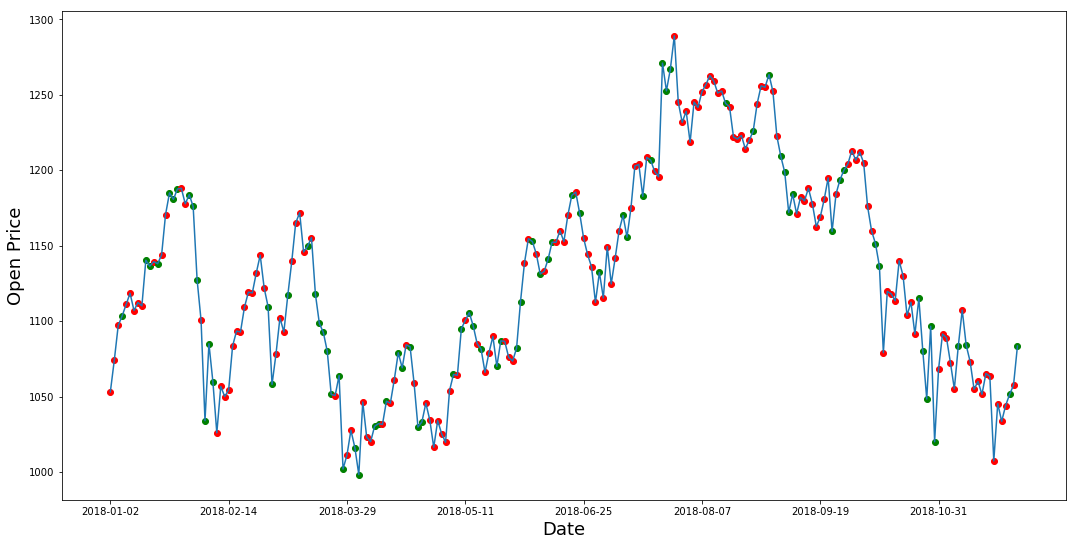

In [82]:
plt.figure(figsize = (18,9))
plt.plot(range(0,len(g_open_y)),g_open_y)
plt.xticks(range(0,len(g_open_x),30),g_open_x[::30])
plt.xlabel('Date',fontsize=18)
plt.ylabel('Open Price',fontsize=18)
for i in range(0,len(y_pre)):
    a,b,c = y_pre[i]
    if a>=b and a>c:
        plt.scatter(i,g_open_y[i],color='g',marker='o')
    elif c>a and c>=b:
        plt.scatter(i,g_open_y[i],color='r',marker='o')
    else:
        plt.scatter(i,g_open_y[i],color='y',marker='*') 
plt.show()